<a href="https://colab.research.google.com/github/rafaelagrc/Tentativa/blob/main/Tentativa1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

from tensorflow.keras.preprocessing import image_dataset_from_directory

_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)
PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

train_dir = PATH; #os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

BATCH_SIZE = 32
IMG_SIZE = (160, 160)

train_dataset = image_dataset_from_directory(train_dir,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)

validation_dataset = image_dataset_from_directory(validation_dir,
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE,
                                                  image_size=IMG_SIZE)

Found 3000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


In [ ]:
class_names = train_dataset.class_names
class_names

['cats', 'dogs']

Como o conjunto de dados original não contém um conjunto de teste, você criará um. Para fazer isso, determine quantos lotes de dados estão disponíveis no conjunto de validação usando tf.data.experimental.cardinality e mova 20% deles para um conjunto de teste

In [ ]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

Data Augmentation:

In [ ]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

Em um momento, você fará o download de tf.keras.applications.MobileNetV2 para usar como seu modelo básico. Este modelo espera valores de pixel em [-1,1] , mas neste ponto, os valores de pixel em suas imagens estão em [0-255] . Para redimensioná-los, use o método de pré-processamento incluído no modelo.

In [ ]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
rescale = tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5, offset= -1)

O modelo MobileNet V2 pré-carregado com pesos treinados no ImageNet. Ao especificar o argumento include_top = False , você carrega uma rede que não inclui as camadas de classificação no topo, o que é ideal para extração de recursos.

In [ ]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [ ]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


congelar a base convolucional antes de compilar e treinar o modelo:

In [ ]:
base_model.trainable = False

In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)

prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)

Construa um modelo encadeando as camadas de aumento de dados, reescalonamento, base_model e extrator de características usando a API funcional Keras . Conforme mencionado anteriormente, use training = False, pois nosso modelo contém uma camada BatchNormalization.

In [ ]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [ ]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

Accuracy antes de ajustarmos aos nossos dados:

In [ ]:
initial_epochs = 3

loss0, accuracy0 = model.evaluate(validation_dataset)

26/26 [==============================] - 17s 582ms/step - loss: 0.8644 - accuracy: 0.4649


In [ ]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/3
63/63 [==============================] - 64s 970ms/step - loss: 0.7170 - accuracy: 0.5850 - val_loss: 0.5662 - val_accuracy: 0.6584
Epoch 2/3
63/63 [==============================] - 59s 927ms/step - loss: 0.5404 - accuracy: 0.7025 - val_loss: 0.4107 - val_accuracy: 0.7809
Epoch 3/3
63/63 [==============================] - 58s 921ms/step - loss: 0.4338 - accuracy: 0.7810 - val_loss: 0.3222 - val_accuracy: 0.8502


Curvas de Aprendizagem:

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

Desempenho:

In [ ]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

6/6 [==============================] - 4s 600ms/step - loss: 0.3101 - accuracy: 0.8906
Test accuracy : 0.890625


**PREVISÃO**

Predictions:
 [1 0 0 0 0 1 1 0 0 0 0 1 0 1 0 0 0 1 1 0 1 1 0 1 0 1 0 1 1 0 0 0]
Labels:
 [1 0 0 0 0 1 1 0 0 0 0 1 0 1 1 0 0 1 1 0 1 1 1 1 0 1 0 1 1 0 0 0]


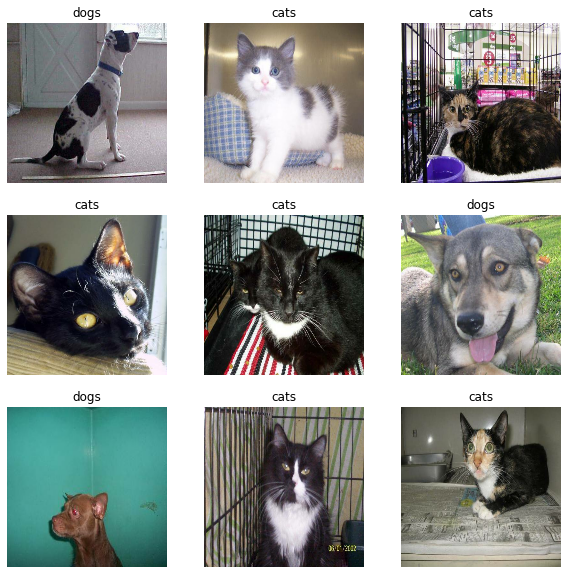

In [ ]:
#Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")